# Overturning Stream Function 

In this notebook we look at the overturning stream function that is obtained from the layers package, and the quasi-stokes stream function approximation that is present in McDougall and McIntosh 2001. 

In [2]:
# load modules 

import xarray as xr
from xmitgcm import open_mdsdataset
from matplotlib import pyplot as plt
from xgcm import Grid
import numpy as np
%matplotlib inline

## Quasi-Stokes Approx (TRM1,2)

\begin{equation}
\Psi = -\frac{\overline{\mathbf{V}'T'}}{\overline{T}_Z} + \frac{\overline{\mathbf{V}}_Z}{\overline{T}_Z}\left(\frac{\overline{\phi}}{\overline{T}_Z} \right) + O (\alpha^3)
\end{equation}

where $T$ is buoyancy (only temperature in our simulation), and $\overline{V} = (\overline{u},\overline{v})$. Thus, $\Psi$ is a 2D stream function, which is sufficient to represent any 3D non-divergent flow. 

This is the stream function from McDougall and McIntosh 2001

Modified mean temperature (density/ buoyancy)
\begin{equation}
\tilde{T} = \overline{T} - \left( \frac{\overline{\phi}}{ \overline{T}_z} \right)_z + O(\alpha^3) 
\end{equation}

In [3]:
Lcoarse= 50e3

In [4]:
Model_Tav = xr.open_dataset('./outputs_ncfiles/Model_Tav.nc')

In [8]:
diff_tensor = xr.open_dataset('./outputs_ncfiles/diff_tensor_'+str(int(Lcoarse//1e3))+'km.nc')
#Trac_coarse = xr.open_dataset('./outputs_ncfiles/Trac_coarse_'+str(int(Lcoarse//1e3))+'km.nc')
Vels_coarse = xr.open_dataset('./outputs_ncfiles/Vels_coarse_'+str(int(Lcoarse//1e3))+'km')
T_coarse    = xr.open_dataset('./outputs_ncfiles/T_coarse_'+str(int(Lcoarse//1e3))+'km')

## When using only time average

Evaluate the streamfunction with only time averaging

In [10]:
grid = Grid(Model_Tav, periodic='X')

In [11]:
# Quasi-Stokes  (equation 4b)
T_z = -grid.interp(grid.diff(Model_Tav.Ttave, 'Z', boundary='extend'), 'Z', boundary='extend')/Model_Tav.drF
U_z = -grid.interp(grid.interp(grid.diff(Model_Tav.uVeltave,'Z', boundary='extend'), 'Z', boundary='extend'), 'X')/Model_Tav.drF
V_z = -grid.interp(grid.interp(grid.diff(Model_Tav.vVeltave,'Z', boundary='extend'), 'Z', boundary='extend'), 'Y', boundary='extend')/Model_Tav.drF
UpTp = grid.interp(Model_Tav.UTtave,'X') - grid.interp(Model_Tav.uVeltave, 'X')*Model_Tav.Ttave
VpTp = grid.interp(Model_Tav.VTtave,'Y', boundary='extend') - grid.interp(Model_Tav.vVeltave, 'Y', boundary='extend')*Model_Tav.Ttave
phi = Model_Tav.TTtave - Model_Tav.Ttave**2

# the first and second terms in the stream function
Psix1 = - UpTp/T_z
Psiy1 = - VpTp/T_z

Psix2 = U_z*phi/T_z/T_z
Psiy2 = V_z*phi/T_z/T_z

# When using time+space average

Use the coarse grained data. 

In [12]:
gridC = Grid(T_coarse, periodic='X')

In [13]:
# Quasi-Stokes  (equation 4b)
TC_z = -grid.interp(grid.diff(T_coarse['T'], 'Z', boundary='extend'), 'Z', boundary='extend')/Model_Tav.drF
UC_z = -grid.interp(grid.diff(Vels_coarse.U,'Z', boundary='extend'), 'Z', boundary='extend')/Model_Tav.drF
VC_z = -grid.interp(grid.diff(Vels_coarse.V,'Z', boundary='extend'), 'Z', boundary='extend')/Model_Tav.drF
UCpTCp = T_coarse.UpTp
VCpTCp = T_coarse.VpTp

phiC = T_coarse.TpTp

# the first and second terms in the stream function
PsiCx1 = - UCpTCp/TC_z
PsiCy1 = - VCpTCp/TC_z

PsiCx2 = UC_z*phiC/TC_z/TC_z
PsiCy2 = VC_z*phiC/TC_z/TC_z

/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


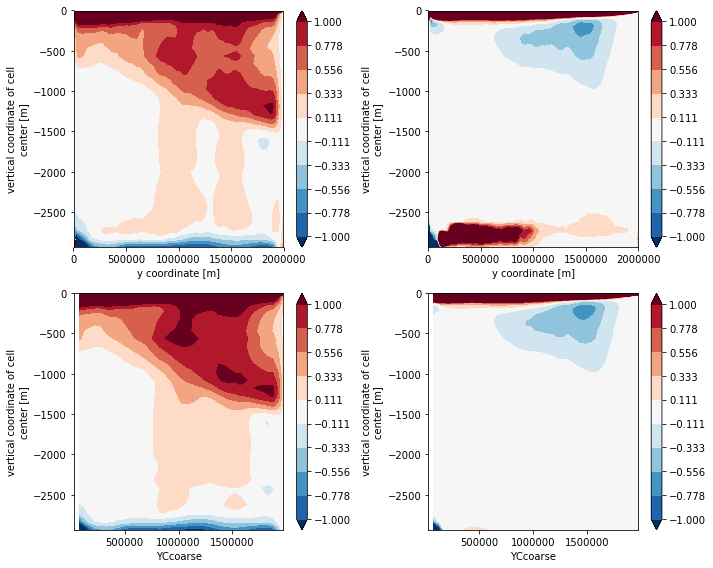

In [14]:
plt.figure(figsize=(10,8))
plt.subplot(221)
(Psiy1.where(Model_Tav.hFacC==1)).mean('XC').plot.contourf(levels=10, vmin=-1)

plt.subplot(222)
(Psiy2.where(Model_Tav.hFacC==1)).mean('XC').plot.contourf(levels=10,vmin=-1)

plt.subplot(223)
(PsiCy1.where(T_coarse.hFacCcoarse==1)).mean('XCcoarse').plot.contourf(levels=10, vmin=-1)

plt.subplot(224)
(PsiCy2.where(T_coarse.hFacCcoarse==1)).mean('XCcoarse').plot.contourf(levels=10,vmin=-1)
plt.tight_layout()

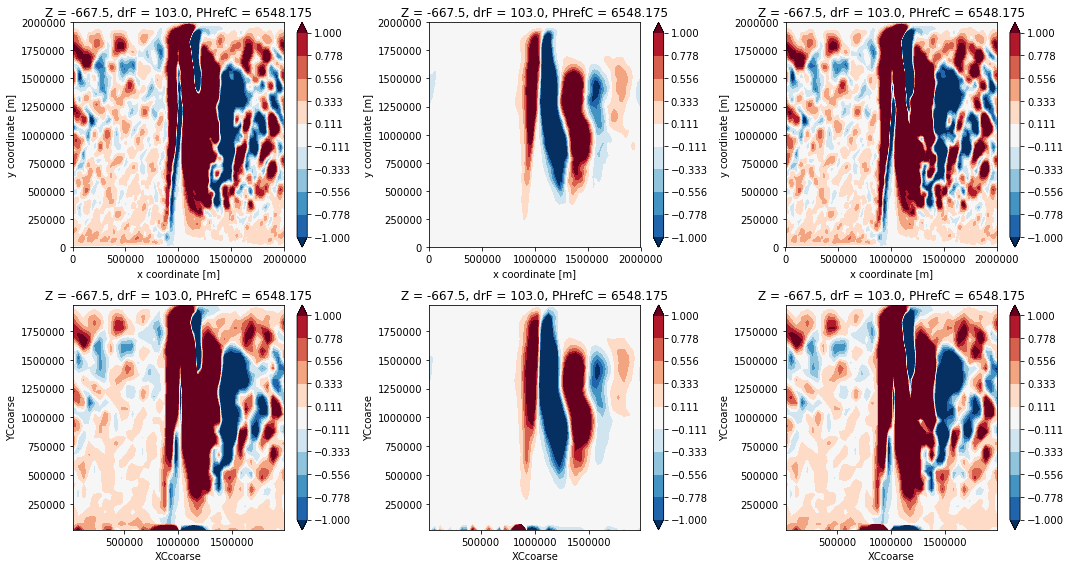

In [19]:
plt.figure(figsize=(15,8))

zloc = -700
plt.subplot(231)
Psiy1.sel(Z=zloc, method='nearest').plot.contourf(levels=10, vmin=-1)

plt.subplot(232)
Psiy2.sel(Z=zloc, method='nearest').plot.contourf(levels=10,vmin=-1)

plt.subplot(233)
(Psiy1 + Psiy2).sel(Z=zloc, method='nearest').plot.contourf(levels=10,vmin=-1)


plt.subplot(234)
PsiCy1.sel(Z=zloc, method='nearest').plot.contourf(levels=10, vmin=-1)

plt.subplot(235)
PsiCy2.sel(Z=zloc, method='nearest').plot.contourf(levels=10,vmin=-1)

plt.subplot(236)
(PsiCy1 + PsiCy2).sel(Z=zloc, method='nearest').plot.contourf(levels=10,vmin=-1)


plt.tight_layout()


In [24]:
X = Trac_coarse.XCcoarse/1e3

### All the action is downstream. Can look at a cumsum plot for the stream function. 


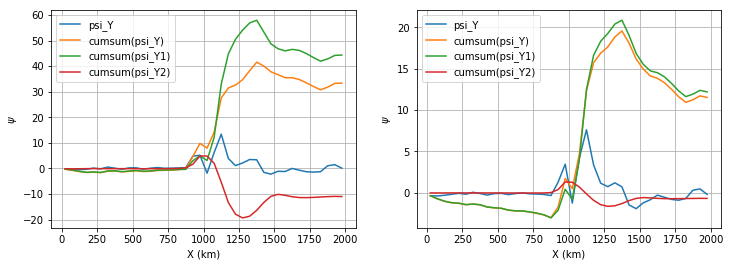

In [33]:
# All the action is downstream. Can look at a cumsum plot for the stream function. 

plt.figure(figsize=(12,4))

plt.subplot(121)
plt.plot(X, (PsiCy1+PsiCy2).sel(YCcoarse=1000e3, Z=-600, method='nearest'), label='psi_Y')
plt.plot(X, np.cumsum((PsiCy1+PsiCy2).sel(YCcoarse=1000e3, Z=-600, method='nearest')), label='cumsum(psi_Y)')
plt.plot(X, np.cumsum((PsiCy1).sel(YCcoarse=1000e3, Z=-600, method='nearest')), label='cumsum(psi_Y1)')
plt.plot(X, np.cumsum((PsiCy2).sel(YCcoarse=1000e3, Z=-600, method='nearest')), label='cumsum(psi_Y2)')

plt.xlabel('X (km)')
plt.ylabel('$\psi$')
plt.legend()
plt.grid()

plt.subplot(122)
plt.plot(X, (PsiCy1+PsiCy2).sel(YCcoarse=1000e3, Z=-1600, method='nearest'), label='psi_Y')
plt.plot(X, np.cumsum((PsiCy1+PsiCy2).sel(YCcoarse=1000e3, Z=-1600, method='nearest')), label='cumsum(psi_Y)')
plt.plot(X, np.cumsum((PsiCy1).sel(YCcoarse=1000e3, Z=-1600, method='nearest')), label='cumsum(psi_Y1)')
plt.plot(X, np.cumsum((PsiCy2).sel(YCcoarse=1000e3, Z=-1600, method='nearest')), label='cumsum(psi_Y2)')

plt.xlabel('X (km)')
plt.ylabel('$\psi$')
plt.legend()
plt.grid()

## Maybe one cares about the eddy driven velocity instead 

In [39]:
Veddy1 = -grid.interp(grid.diff(PsiCy1, 'Z', boundary='extend'),'Z', boundary='extend')/ PsiCy1.drF
Veddy2 = -grid.interp(grid.diff(PsiCy2, 'Z', boundary='extend'),'Z', boundary='extend')/ PsiCy2.drF
Vmean = Vels_coarse.V

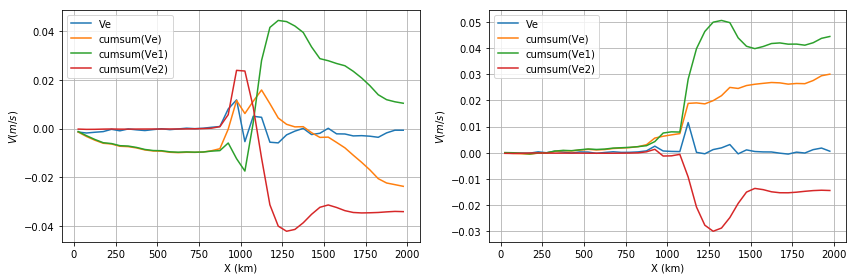

In [43]:
# All the action is downstream. Can look at a cumsum plot for the stream function. 

plt.figure(figsize=(12,4))

plt.subplot(121)
plt.plot(X, (Veddy1+Veddy2).sel(YCcoarse=1000e3, Z=-600, method='nearest'), label='Ve')
plt.plot(X, np.cumsum((Veddy1+Veddy2).sel(YCcoarse=1000e3, Z=-600, method='nearest')), label='cumsum(Ve)')
#plt.plot(X, np.cumsum((Vmean).sel(YCcoarse=1000e3, Z=-600, method='nearest')), label='cumsum(Vm)')
plt.plot(X, np.cumsum((Veddy1).sel(YCcoarse=1000e3, Z=-600, method='nearest')), label='cumsum(Ve1)')
plt.plot(X, np.cumsum((Veddy2).sel(YCcoarse=1000e3, Z=-600, method='nearest')), label='cumsum(Ve2)')

plt.xlabel('X (km)')
plt.ylabel('$V (m/s)$')
plt.legend()
plt.grid()

plt.subplot(122)
plt.plot(X, (Veddy1+Veddy2).sel(YCcoarse=1000e3, Z=-900, method='nearest'), label='Ve')
plt.plot(X, np.cumsum((Veddy1+Veddy2).sel(YCcoarse=1000e3, Z=-900, method='nearest')), label='cumsum(Ve)')
plt.plot(X, np.cumsum((Veddy1).sel(YCcoarse=1000e3, Z=-900, method='nearest')), label='cumsum(Ve1)')
plt.plot(X, np.cumsum((Veddy2).sel(YCcoarse=1000e3, Z=-900, method='nearest')), label='cumsum(Ve2)')

plt.xlabel('X (km)')
plt.ylabel('$V (m/s)$')
plt.legend()
plt.grid()

plt.tight_layout()

In [46]:
Vsum1 = Veddy1.sum('XCcoarse')*Veddy1.drF
Vsum2 = Veddy2.sum('XCcoarse')*Veddy2.drF

Text(0.5, 1.0, 'sum(Ved2)/sum(Ved1) - Relative contributions')

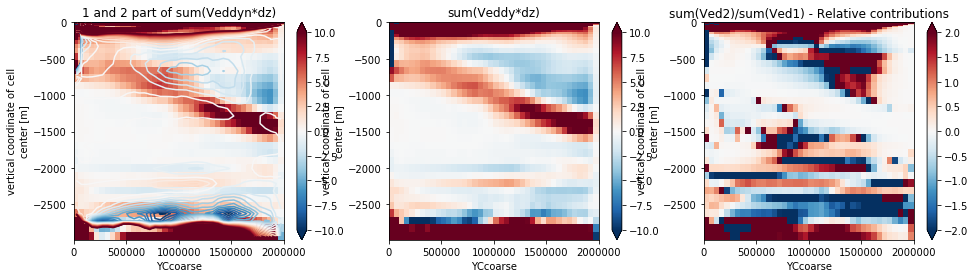

In [80]:
plt.figure(figsize=(16,4))


plt.subplot(131)
Vsum1.plot(vmax=10)
Vsum2.plot.contour(vmax=10, levels=25)
plt.title('1 and 2 part of sum(Veddyn*dz)')

plt.subplot(132)
(Vsum1 + Vsum2).plot(vmax=10)
plt.title('sum(Veddy*dz)')

plt.subplot(133)
(Vsum2/Vsum1).plot(vmax=2)
plt.title('sum(Ved2)/sum(Ved1) - Relative contributions')


### Notes: 
- Is the variance transport another way to talk about the stationary eddy flux? It has a massive component, and often opposes the influence of the transient eddies. 
- Are these results specific to my simulations? 

# What about $\psi_1$ and $\psi_2$ from $\mathbf{A}$? Is there some similarity with the streamfunctions from TRM?

From TRM we have:
\begin{equation}
\psi^{TRM} = -\frac{\overline{\mathbf{V}'T'}}{\overline{T}_Z} + \frac{\overline{\mathbf{V}}_Z}{\overline{T}_Z}\left(\frac{\overline{\phi}}{\overline{T}_Z} \right) + O (\alpha^3)
\end{equation}
The b flux on the RHS is the full b flux. 

From the effective transport asymetric tensor we have:
\begin{equation}\label{A}
\mathbf{A}  = %=\varepsilon^{mnp}\psi_p = 
\begin{bmatrix}
~0 & ~\psi_3 & -\psi_2\\
-\psi_3 & ~0 & ~\psi_1\\
~\psi_2 & -\psi_1 & ~0 
\end{bmatrix},
\end{equation}
This implies a buoyancy flux $\overline{u'b'} = \psi_3 b_y - \psi_2 b_z$ and $\overline{v'b'} = -\psi_3 b_x + \psi_1 b_z$.


The way the TRM stream function and the streamfunction from $\mathbf{A}$ could be the same is if three conditions are met:
a) $\mathbf{S}\nabla B \approx 0$. This not true, and this term actually ends up being almost the same order as $\mathbf{A}\nabla B$, but opposite sign. 
b) $\psi_3 \approx 0$, or $\psi_3 b_y << -\psi_2 b_z$. This is not true either. 
c) the variance transport contribution to $\psi^{TRM} \approx 0$. This is not true. Even in a zonal average usually the contribution from this term is small but in some regions it can be dominant.

This implies that the two stream functions will not be comparable, but let's check anyways (!). 

The two comparative elements (if they were) would be $\psi_1^{TRM}$ with $\psi_2^A$, and $\psi_2^{TRM}$ with $-\psi_1^A$, where the TRM terms are without the variance transport part.



In [29]:
diff_tensor.ATcorr
Apsi1 = diff_tensor.ATcorr.isel(i=1, j=2)
Apsi2 = -diff_tensor.ATcorr.isel(i=0, j=2)
Apsi3 = diff_tensor.ATcorr.isel(i=0, j=1)

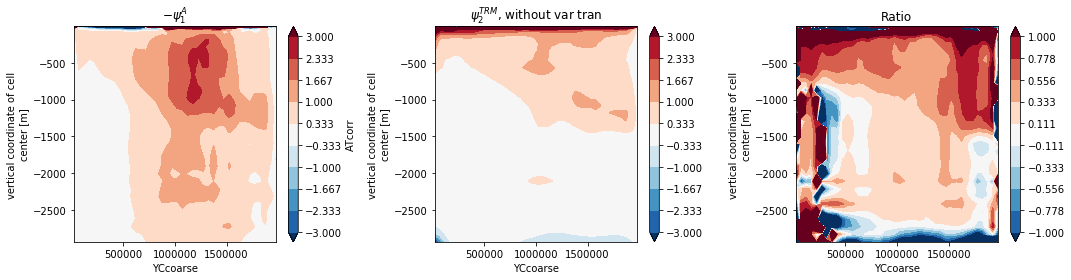

In [18]:
# 

plt.figure(figsize=(15,4))

plt.subplot(131)
Apsi1.mean('XCcoarse').plot.contourf(vmin=-3, levels=10)
plt.title('$-\psi_1^A$')


plt.subplot(132)
(PsiCy1).mean('XCcoarse').plot.contourf(vmin=-3, levels=10)
plt.title('$\psi_{2}^{TRM}$, without var tran')

plt.subplot(133)
(PsiCy1.mean('XCcoarse')/Apsi1.mean('XCcoarse')).plot.contourf(vmin=-1, levels=10)
plt.title('Ratio')

plt.tight_layout()

In [20]:
Tstationary = T_coarse['T'] - T_coarse['T'].mean('XCcoarse')

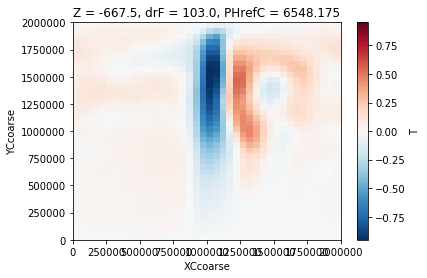

In [26]:
Tstationary.sel(Z=-700, method='nearest').plot()

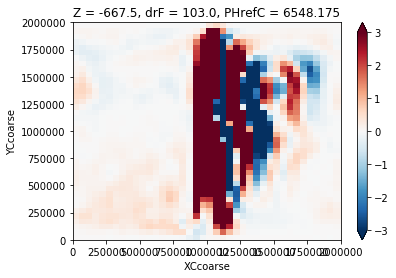

In [28]:
(-Vels_coarse.V*Tstationary/T_coarse['T_Z']).sel(Z=-700, method='nearest').plot(vmin=-3)

In [ ]:
Vels_coarse.

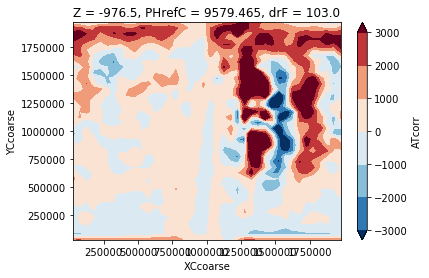

In [33]:

Apsi3.sel(Z=-1000, method='nearest').plot.contourf(vmin=-3000)

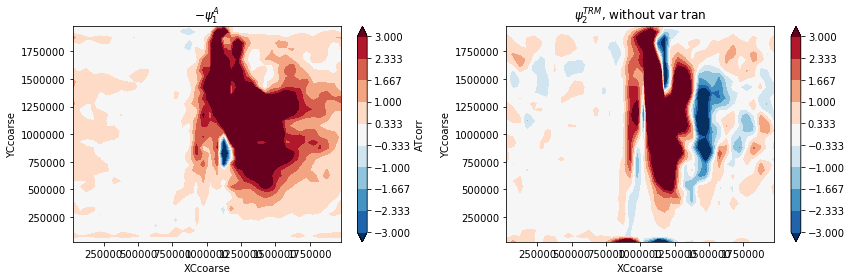

In [25]:
# 
plt.figure(figsize=(12,4))

plt.subplot(121)
Apsi1.sel(Z=-700, method='nearest').plot.contourf(vmin=-3, levels=10)
plt.title('$-\psi_1^A$')


plt.subplot(122)
(PsiCy1).sel(Z=-700, method='nearest').plot.contourf(vmin=-3, levels=10)
plt.title('$\psi_{2}^{TRM}$, without var tran')

plt.tight_layout()

# Can we calculate a Kgm from TRM or A? 
One can obviously calculate a coefficient from both stream functions. However, the coefficient corresponding to the asymtensor would not be GM. 

If GM was to parameterize the streamfunctions then $\psi_1^{TRM} = - K_{GM} s_x$; $\psi_2^{TRM} = - K_{GM} s_y$.


In [85]:
Sx = - T_coarse.T_X/ T_coarse.T_Z
Sy = - T_coarse.T_Y/ T_coarse.T_Z

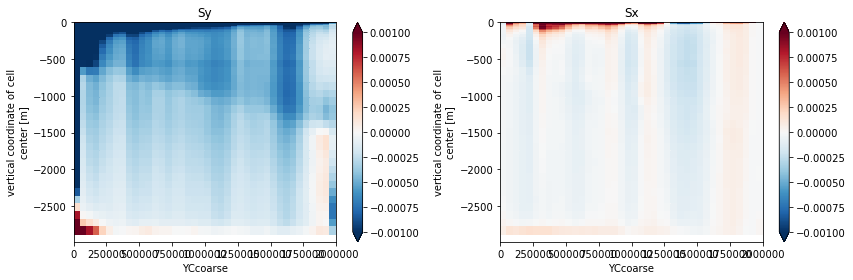

In [91]:
plt.figure(figsize=(12,4))

plt.subplot(121)
Sy.sel(XCcoarse=0, method='nearest').plot(vmin=-1e-3)
plt.title('Sy')

plt.subplot(122)
Sx.sel(XCcoarse=0, method='nearest').plot(vmin=-1e-3)
plt.title('Sx')

plt.tight_layout()

In [92]:
Kgmx = - (PsiCx1+PsiCx2)/Sx
Kgmy = - (PsiCy1+PsiCy2)/Sy

In [96]:
Kgmy_zonmean = - (PsiCy1+PsiCy2).mean('XCcoarse')/Sy.mean('XCcoarse')

/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


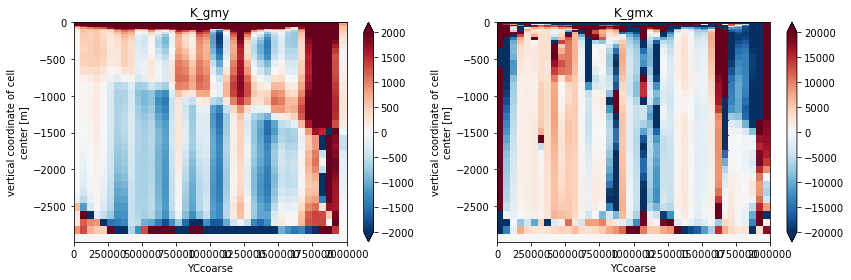

In [101]:
plt.figure(figsize=(12,4))

plt.subplot(121)
Kgmy.sel(XCcoarse=0, method='nearest').plot(vmin=-2000)
plt.title('K_gmy')

plt.subplot(122)
Kgmx.sel(XCcoarse=0, method='nearest').plot(vmin=-20000)
plt.title('K_gmx')

plt.tight_layout()

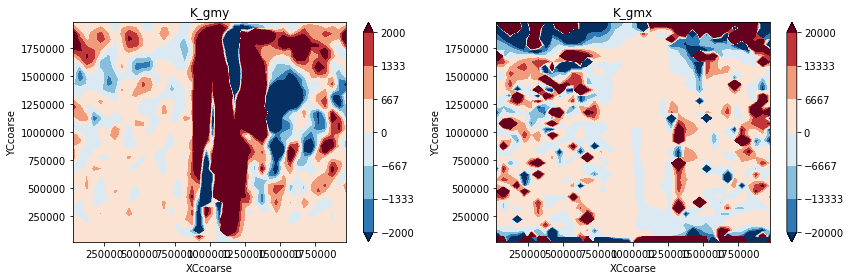

In [105]:
plt.figure(figsize=(12,4))

plt.subplot(121)
Kgmy.sel(Z=-700, method='nearest').plot.contourf(vmin=-2000)
plt.title('K_gmy')

plt.subplot(122)
Kgmx.sel(Z=-700, method='nearest').plot.contourf(vmin=-20000)
plt.title('K_gmx')

plt.tight_layout()

Text(0.5, 1.0, 'K_gm zonal mean')

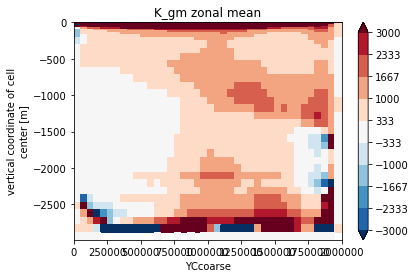

In [104]:
Kgmy_zonmean.plot(vmin=-3000, levels=10)
plt.title('K_gm zonal mean')

## Note 
When we try to estimate Kgm directly from the TRM stream function we get a lot of positive and negative values. The Kgm in the X and Y direction are also very different.
This is indicative that ... maybe the rotational flux messes up the results. We should try to compute a Kgm from the divergence. 


## How to compute K_gm? 

The above "failure" of being able to estimate a Kgm directly from the stream function points at the age old problem of rotational fluxes. The way to compute the Kgm does need to appeal to the divergence eventually. 
However, this can't be done simply by considering the divergence (advection by Quasi-stokes term): 
\begin{equation}
\mathbf{U}^{QS}. \nabla B = \mathbf{\psi}_z . \nabla_H B - B_z \nabla_H. \mathbf{\psi} =  -(\kappa \mathbf{s})_z . \nabla_H B + B_z \nabla_H. (\kappa \mathbf{s}) 
\end{equation}
Then the functional fit to $\kappa (x,y,z)$ or $\kappa (x,y)$ would need to be done using some minimization technique. 

It is not guaranteed that this would result in a positive definite field either (!!). 

### Vague GM 

For now let us try to approximate a Kgm simply. 

By simply I mean, assume that it is a constant in some region. 

In [185]:
# lets use only the time average for this as it is easier to calculate the gradients with it. 

Psix = (Psix1 + Psix2)
Psiy = (Psiy1 + Psiy2)

divHPsi = grid.interp(grid.diff(Psix, 'X'), 'X')/5e3 + grid.interp(grid.diff(Psiy, 'Y', boundary='extend'), 'Y', boundary='extend')/5e3
Psix_z = -grid.interp(grid.diff(Psix, 'Z', boundary='extend'), 'Z', boundary='extend')/ Psix.drF
Psiy_z = -grid.interp(grid.diff(Psiy, 'Z', boundary='extend'), 'Z', boundary='extend')/ Psiy.drF

Tx = grid.interp(grid.diff(Model_Tav.Ttave, 'X'),'X')/5e3
Ty = grid.interp(grid.diff(Model_Tav.Ttave, 'Y', boundary='extend'),'Y', boundary='extend')/5e3
Tz = -grid.interp(grid.diff(Model_Tav.Ttave, 'Z', boundary='extend'), 'Z', boundary='extend')/ Model_Tav.drF

Sx = -Tx/Tz
Sy = -Ty/Tz

divHS = grid.interp(grid.diff(Sx, 'X'), 'X')/5e3 + grid.interp(grid.diff(Sy, 'Y', boundary='extend'), 'Y', boundary='extend')/5e3
Sx_z = -grid.interp(grid.diff(Sx, 'Z', boundary='extend'), 'Z', boundary='extend')/ Sx.drF
Sy_z = -grid.interp(grid.diff(Sy, 'Z', boundary='extend'), 'Z', boundary='extend')/ Sy.drF

/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/xgcm/grid.py:1001: RuntimeWarning: invalid value encountered in add
  return 0.5*(data_left + data_right)
/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/xgcm/grid.py:1005: RuntimeWarning: invalid value encountered in subtract
  return data_right - data_left


In [186]:
divHPsi1 = grid.interp(grid.diff(Psix1, 'X'), 'X')/5e3 + grid.interp(grid.diff(Psiy1, 'Y', boundary='extend'), 'Y', boundary='extend')/5e3
Psix1_z = -grid.interp(grid.diff(Psix1, 'Z', boundary='extend'), 'Z', boundary='extend')/ Psix.drF
Psiy1_z = -grid.interp(grid.diff(Psiy1, 'Z', boundary='extend'), 'Z', boundary='extend')/ Psiy.drF

In [187]:
divPsib =  ( Psix_z * Tx + Psiy_z * Ty - divHPsi*Tz)
divPsi1b = ( Psix1_z * Tx + Psiy1_z * Ty - divHPsi1*Tz)
divSb =  -( Sx_z * Tx + Sy_z * Ty - divHS*Tz)

In [160]:
divPsib.load()
divSb.load()

<xarray.DataArray (Z: 40, YC: 400, XC: 400)>
array([[[          nan,           nan, ...,           nan,           nan],
        [          inf,           inf, ...,           inf,           inf],
        ...,
        [ 2.514946e-09,  2.483869e-09, ...,  2.583099e-09,  2.550481e-09],
        [ 2.657256e-09,  2.641970e-09, ...,  2.708357e-09,  2.680487e-09]],

       [[          nan,           nan, ...,           nan,           nan],
        [          inf,           inf, ...,           inf,           inf],
        ...,
        [ 1.275630e-09,  1.247810e-09, ...,  1.335518e-09,  1.307288e-09],
        [ 6.628821e-10,  6.501382e-10, ...,  6.920576e-10,  6.785096e-10]],

       ...,

       [[          nan,           nan, ...,           nan,           nan],
        [         -inf,          -inf, ...,          -inf,          -inf],
        ...,
        [-3.523642e-11, -3.309528e-11, ..., -4.410061e-11, -4.025879e-11],
        [ 2.040743e-11,  2.263537e-11, ...,  1.833830e-11,  1.891014e-11]]

Text(0.5, 1.0, 'S')

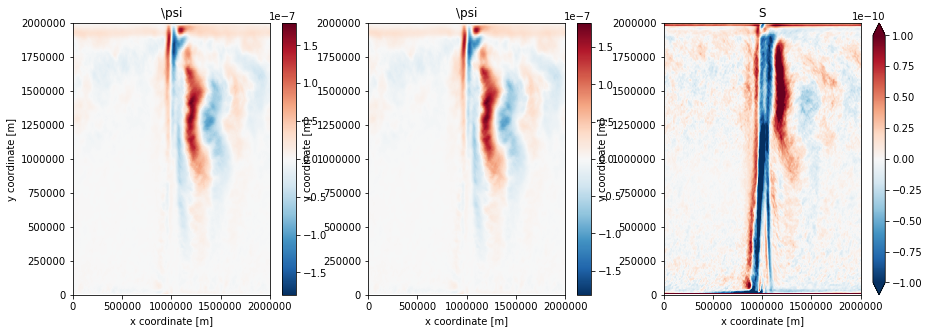

In [189]:
plt.figure(figsize=(15,5))

plt.subplot(131)
divPsib.sel(Z=-1000, method='nearest').plot()
plt.title('\psi')

plt.subplot(132)
divPsi1b.sel(Z=-1000, method='nearest').plot()
plt.title('\psi')

plt.subplot(133)
divSb.sel(Z=-1000, method='nearest').plot(vmin=-1e-10)
plt.title('S')

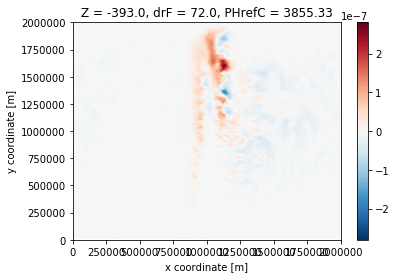

In [192]:
(divPsi1b.sel(Z=-400, method='nearest') - divPsib.sel(Z=-400, method='nearest')).plot()


Text(0.5, 1.0, 'Upstream')

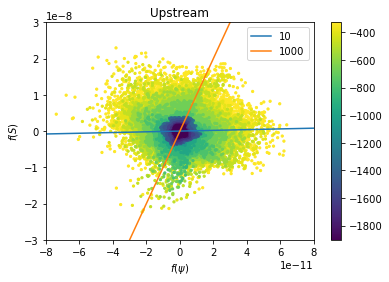

In [181]:
zloc1 = -300
zloc2 = -2000
yloc1 = 800e3
yloc2 = 1200e3
xloc1 = 300e3
xloc2 = 700e3

[Z, Y, X] = np.meshgrid(Model_Tav.Z.sel(Z=slice(zloc1, zloc2)), 
                        Model_Tav.YC.sel(YC = slice(yloc1, yloc2)), 
                        Model_Tav.XC.sel(XC = slice(xloc1, xloc2)), indexing='ij')

plt.scatter(divSb.sel(XC=slice(xloc1,xloc2), YC=slice(yloc1, yloc2), Z=slice(zloc1, zloc2)),
        divPsib.sel(XC=slice(xloc1,xloc2), YC=slice(yloc1, yloc2), Z=slice(zloc1, zloc2)),c= Z, s=5)

plt.plot(np.array([-8e-11, 8e-11]), 10*np.array([-8e-11, 8e-11]), label='10')
plt.plot(np.array([-8e-11, 8e-11]), 1000*np.array([-8e-11, 8e-11]), label='1000')

plt.legend()
plt.ylim([-3e-8, 3e-8])
plt.xlim([-8e-11, 8e-11])
plt.xlabel('$f(\psi)$')
plt.ylabel('$f(S)$')
plt.colorbar()
plt.title('Upstream')

KeyboardInterrupt: 

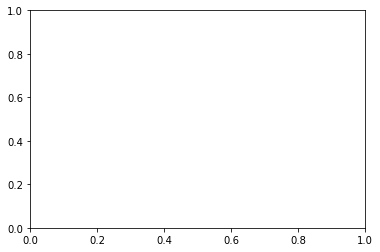

In [156]:
plt.hist2d(divPsib.sel(XC=slice(xloc1,xloc2), YC=slice(yloc1, yloc2), Z=slice(zloc1, zloc2)), 
            divSb.sel(XC=slice(xloc1,xloc2), YC=slice(yloc1, yloc2), Z=slice(zloc1, zloc2)), 
          bins = [np.linspace(-3e-8,3e-8,20), np.linspace(-1e-10, 1e-10,20)])

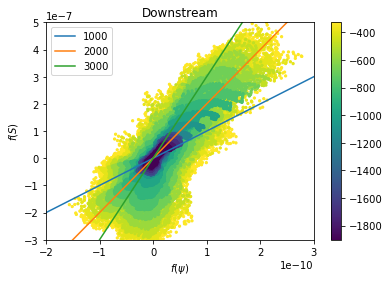

In [193]:
zloc1 = -300
zloc2 = -2000
yloc1 = 600e3
yloc2 = 1400e3
xloc1 = 1200e3
xloc2 = 1900e3

[Z, Y, X] = np.meshgrid(Model_Tav.Z.sel(Z=slice(zloc1, zloc2)), 
                        Model_Tav.YC.sel(YC = slice(yloc1, yloc2)), 
                        Model_Tav.XC.sel(XC = slice(xloc1, xloc2)), indexing='ij')


plt.scatter(divSb.sel(XC=slice(xloc1,xloc2), YC=slice(yloc1, yloc2), Z=slice(zloc1, zloc2)),
        divPsib.sel(XC=slice(xloc1,xloc2), YC=slice(yloc1, yloc2), Z=slice(zloc1, zloc2)),c= Z, s=5)
plt.plot(np.array([-2e-10, 4e-10]), 1000*np.array([-2e-10, 4e-10]), label='1000')
plt.plot(np.array([-2e-10, 4e-10]), 2000*np.array([-2e-10, 4e-10]), label='2000')
plt.plot(np.array([-2e-10, 4e-10]), 3000*np.array([-2e-10, 4e-10]), label='3000')
plt.legend()
plt.ylim([-3e-7, 5e-7])
plt.xlim([-2e-10, 3e-10])
plt.xlabel('$f(\psi)$')
plt.ylabel('$f(S)$')
plt.title('Downstream')
plt.colorbar()


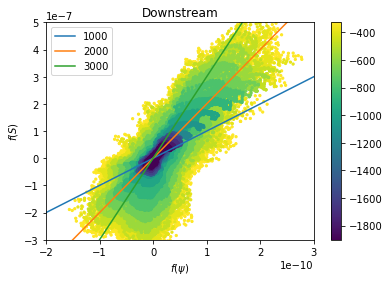

In [194]:
zloc1 = -300
zloc2 = -2000
yloc1 = 600e3
yloc2 = 1400e3
xloc1 = 1200e3
xloc2 = 1900e3

[Z, Y, X] = np.meshgrid(Model_Tav.Z.sel(Z=slice(zloc1, zloc2)), 
                        Model_Tav.YC.sel(YC = slice(yloc1, yloc2)), 
                        Model_Tav.XC.sel(XC = slice(xloc1, xloc2)), indexing='ij')


plt.scatter(divSb.sel(XC=slice(xloc1,xloc2), YC=slice(yloc1, yloc2), Z=slice(zloc1, zloc2)),
        divPsi1b.sel(XC=slice(xloc1,xloc2), YC=slice(yloc1, yloc2), Z=slice(zloc1, zloc2)),c= Z, s=5)
plt.plot(np.array([-2e-10, 4e-10]), 1000*np.array([-2e-10, 4e-10]), label='1000')
plt.plot(np.array([-2e-10, 4e-10]), 2000*np.array([-2e-10, 4e-10]), label='2000')
plt.plot(np.array([-2e-10, 4e-10]), 3000*np.array([-2e-10, 4e-10]), label='3000')
plt.legend()
plt.ylim([-3e-7, 5e-7])
plt.xlim([-2e-10, 3e-10])
plt.xlabel('$f(\psi)$')
plt.ylabel('$f(S)$')
plt.title('Downstream')
plt.colorbar()


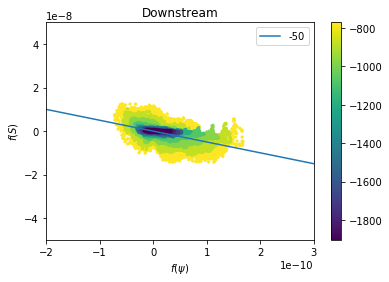

In [203]:
zloc1 = -700
zloc2 = -2000
yloc1 = 600e3
yloc2 = 1400e3
xloc1 = 1200e3
xloc2 = 1900e3

[Z, Y, X] = np.meshgrid(Model_Tav.Z.sel(Z=slice(zloc1, zloc2)), 
                        Model_Tav.YC.sel(YC = slice(yloc1, yloc2)), 
                        Model_Tav.XC.sel(XC = slice(xloc1, xloc2)), indexing='ij')


plt.scatter(divSb.sel(XC=slice(xloc1,xloc2), YC=slice(yloc1, yloc2), Z=slice(zloc1, zloc2)),
        (divPsib - divPsi1b).sel(XC=slice(xloc1,xloc2), YC=slice(yloc1, yloc2), Z=slice(zloc1, zloc2)),c= Z, s=5)
plt.plot(np.array([-2e-10, 4e-10]), -50*np.array([-2e-10, 4e-10]), label='-50')
plt.legend()
plt.ylim([-5e-8, 5e-8])
plt.xlim([-2e-10, 3e-10])
plt.xlabel('$f(\psi)$')
plt.ylabel('$f(S)$')
plt.title('Downstream')
plt.colorbar()


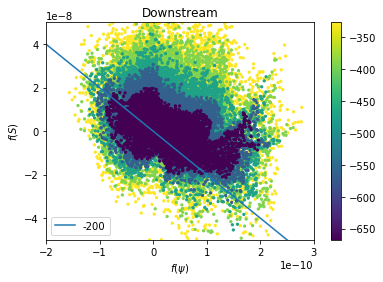

In [202]:
zloc1 = -300
zloc2 = -700
yloc1 = 600e3
yloc2 = 1400e3
xloc1 = 1200e3
xloc2 = 1900e3

[Z, Y, X] = np.meshgrid(Model_Tav.Z.sel(Z=slice(zloc1, zloc2)), 
                        Model_Tav.YC.sel(YC = slice(yloc1, yloc2)), 
                        Model_Tav.XC.sel(XC = slice(xloc1, xloc2)), indexing='ij')


plt.scatter(divSb.sel(XC=slice(xloc1,xloc2), YC=slice(yloc1, yloc2), Z=slice(zloc1, zloc2)),
        (divPsib - divPsi1b).sel(XC=slice(xloc1,xloc2), YC=slice(yloc1, yloc2), Z=slice(zloc1, zloc2)),c= Z, s=5)
plt.plot(np.array([-2e-10, 4e-10]), -200*np.array([-2e-10, 4e-10]), label='-200')
plt.legend()
plt.ylim([-5e-8, 5e-8])
plt.xlim([-2e-10, 3e-10])
plt.xlabel('$f(\psi)$')
plt.ylabel('$f(S)$')
plt.title('Downstream')
plt.colorbar()


### The above analysis could maybe be done slightly more carefully by choosing different depths. This would be like assuming that there is some small depth regime over which Kgm doesn't change much. 

# Where does this all leave us? 
- A is not the same as Agm. 
- $\psi^{TRM}$ can be used potentially for estimating a GM coefficient, but it would not reveal its secrets too easily. 
- Vague GM shows that there is some positivish GM value that is O(2000). However, it is only present in the downstream region. In the upstream region there is no relationship, and the scatter plot is a shotgun pattern. 
- Adding or not the variance transport, doesn't make much difference to vague GM as it is anyways a large average. If anything here it happens to be a small negative contribution. Something like 20% in the thermocline, while less below it. 
- While the variance transport has little contribution to vague GM, it does seem to have decent contribution to V_eddy in some regions (like in the thermocline).

# What can we say about the remaining effective transport tensors, after we remove the TRM stream function from it. This gives an approximate sense of how to parameterize other tracers.

In [6]:
# Modified Mean (equation 11)
Ttilde = Model_Tav.Ttave + grid.interp(grid.diff(phi/T_z, 'Z', boundary='extend'),'Z', boundary='extend')/Model_Tav.drF

# from equation 12
z_pert = -grid.interp(grid.diff(phi/T_z, 'Z', boundary='extend'),'Z', boundary='extend')/Model_Tav.drF/T_z

/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/xgcm/grid.py:1001: RuntimeWarning: invalid value encountered in subtract
  return data_right - data_left
/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/xgcm/grid.py:997: RuntimeWarning: invalid value encountered in add
  return 0.5*(data_left + data_right)
/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/xgcm/grid.py:1001: RuntimeWarning: invalid value encountered in subtract
  return data_right - data_left
/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/xgcm/grid.py:997: RuntimeWarning: invalid value encountered in add
  return 0.5*(data_left + data_right)


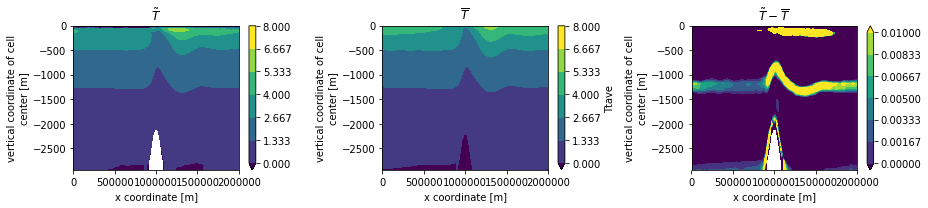

In [10]:
plt.figure(figsize=(13,3))
plt.subplot(131)
Ttilde.sel(YC=1000e3, method='nearest').plot.contourf(vmin=0, vmax=8)
plt.title(r'$\tilde{T}$')

plt.subplot(132)
Model_Tav.Ttave.sel(YC=1000e3, method='nearest').plot.contourf(vmin=0, vmax=8)
plt.title(r'$\overline{T}$')

plt.subplot(133)
(Ttilde - Model_Tav.Ttave).sel(YC=1000e3, method='nearest').plot.contourf(vmin=0, vmax=0.01)
plt.title(r'$\tilde{T} - \overline{T}$')

plt.tight_layout()

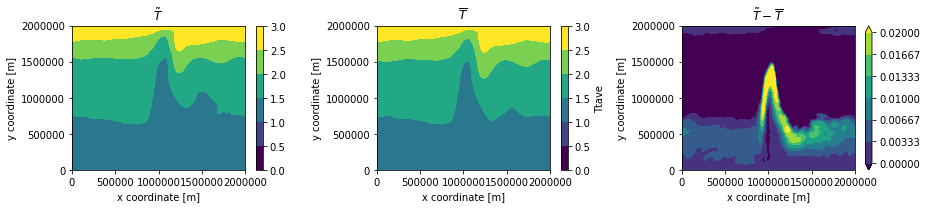

In [16]:
plt.figure(figsize=(13,3))
plt.subplot(131)
Ttilde.sel(Z=-1000, method='nearest').plot.contourf(vmin=0, vmax=3)
plt.title(r'$\tilde{T}$')

plt.subplot(132)
Model_Tav.Ttave.sel(Z=-1000, method='nearest').plot.contourf(vmin=0, vmax=3)
plt.title(r'$\overline{T}$')

plt.subplot(133)
(Ttilde - Model_Tav.Ttave).sel(Z=-1000, method='nearest').plot.contourf(vmin=0, vmax=0.02)
plt.title(r'$\tilde{T} - \overline{T}$')

plt.tight_layout()

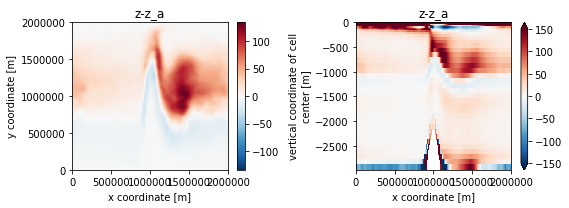

In [18]:
plt.figure(figsize=(8,3))
plt.subplot(121)
z_pert.sel(Z=-1000,method='nearest').plot()
plt.title('z-z_a')

plt.subplot(122)
z_pert.sel(YC=1000e3,method='nearest').plot(vmin=-150)
plt.title('z-z_a')

plt.tight_layout()

/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


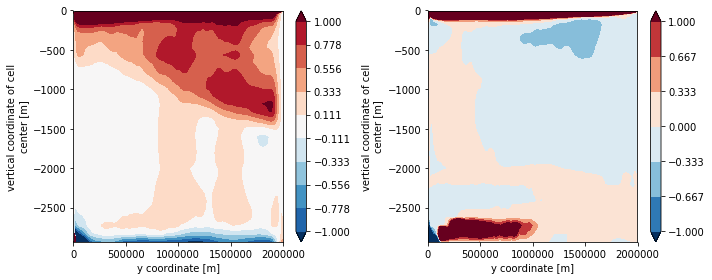

In [14]:
plt.figure(figsize=(10,4))
plt.subplot(121)
(Psi21.where(Model_Tav.hFacC==1)).mean('XC').plot.contourf(levels=10, vmin=-1)

plt.subplot(122)
(Psi22.where(Model_Tav.hFacC==1)).mean('XC').plot.contourf(vmin=-1)
plt.tight_layout()

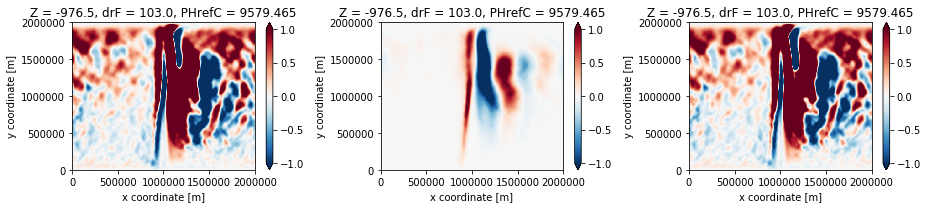

In [88]:
plt.figure(figsize=(13,3))
plt.subplot(131)
(Psi21.where(Model_Tav.hFacC==1)).sel(Z=-1000, method='nearest').plot(vmin=-1)

plt.subplot(132)
(Psi22.where(Model_Tav.hFacC==1)).sel(Z=-1000, method='nearest').plot(vmin=-1)
plt.tight_layout()

plt.subplot(133)
((Psi22 + Psi21).where(Model_Tav.hFacC==1)).sel(Z=-1000, method='nearest').plot(vmin=-1)
plt.tight_layout()

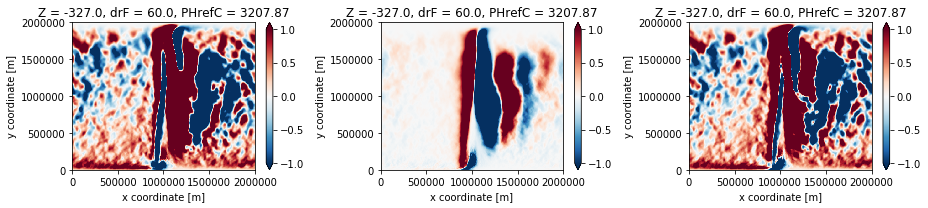

In [106]:
plt.figure(figsize=(13,3))
plt.subplot(131)
(Psi21.where(Model_Tav.hFacC==1)).sel(Z=-300, method='nearest').plot(vmin=-1)

plt.subplot(132)
(Psi22.where(Model_Tav.hFacC==1)).sel(Z=-300, method='nearest').plot(vmin=-1)
plt.tight_layout()

plt.subplot(133)
((Psi22 + Psi21).where(Model_Tav.hFacC==1)).sel(Z=-300, method='nearest').plot(vmin=-1)
plt.tight_layout()

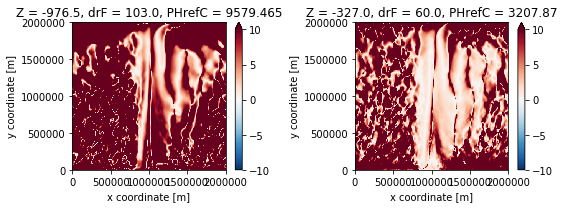

In [109]:
plt.figure(figsize=(8,3))

plt.subplot(121)
np.abs(Psi21/Psi22).sel(Z=-1000, method='nearest').plot(vmin=-10)

plt.subplot(122)
np.abs(Psi21/Psi22).sel(Z=-300, method='nearest').plot(vmin=-10)

plt.tight_layout()

### We can get a Kgm from this quasi-stokes. 

Compring equation 21 in McDougall and McIntosh 2001 with equation 13.141 in Vallis 2019.

$\Psi_x = -K_{gm} S^x$; 
$\Psi_y = -K_{gm} S^y$

Where the slope is $-\nabla \rho / \rho_z$

In [111]:
T_x = grid.interp(grid.diff(Model_Tav.Ttave, 'X'), 'X')/ Model_Tav.dxC[0,0]
T_y = grid.interp(grid.diff(Model_Tav.Ttave, 'Y', boundary='extend'), 'Y', boundary='extend')/ Model_Tav.dyC[0,0]

In [112]:
Sx = - T_x/T_z
Sy = - T_y/T_z 

# Quasi-Stokes Exact (using layers)

In [2]:
data_dir = '/swot/SUM04/dbalwada/channel_model/05km_sponge/run_tracers_restored/'

In [3]:
ds_layers = open_mdsdataset(data_dir,  delta_t=300, prefix=['DiagLAYERS-transport','DiagLAYERS-diapycnal']
                 ,ignore_unknown_vars=True)


ds_trend = open_mdsdataset(data_dir,  
                         delta_t=300, prefix=['DiagLAYERS-trend']
                 ,ignore_unknown_vars=True)

/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/xmitgcm-0.2.2-py3.6.egg/xmitgcm/utils.py:423: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)


In [43]:
ds_layers.time/24/3600/360

<xarray.DataArray 'time' (time: 3)>
array([155., 160., 165.])
Coordinates:
    iter     (time) int64 dask.array<shape=(3,), chunksize=(1,)>
  * time     (time) int64 4821120000 4976640000 5132160000

In [39]:
grid = Grid(ds_layers, periodic='X')

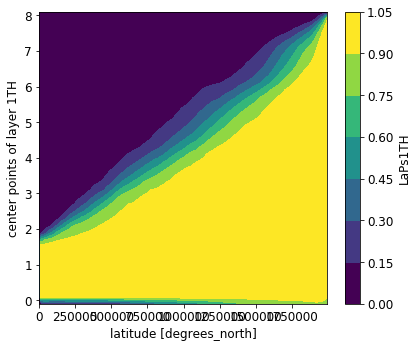

In [30]:
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(6,5))

ds_layers.LaPs1TH.mean(dim=['XC','time']).plot.contourf(levels=10)

plt.tight_layout()


/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)
/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


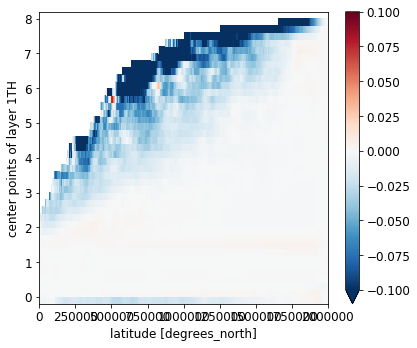

In [23]:
# Thickness 
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(6,5))

(ds_layers.LaVH1TH/ds_layers.LaHs1TH).mean(dim=['XC', 'time']).plot(vmin=-0.1)

plt.tight_layout()

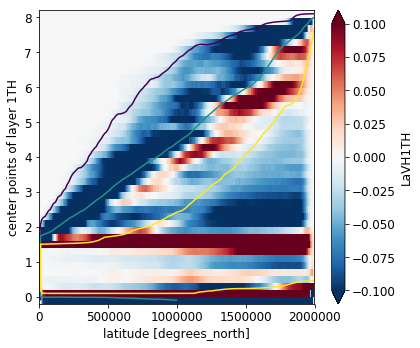

In [34]:
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(6,5))

(ds_layers.LaVH1TH).mean(dim=['XC', 'time']).plot(vmin=-0.1)
ds_layers.LaPs1TH.mean(dim=['XC','time']).plot.contour(levels=[0.01,0.5,.99])

plt.tight_layout()

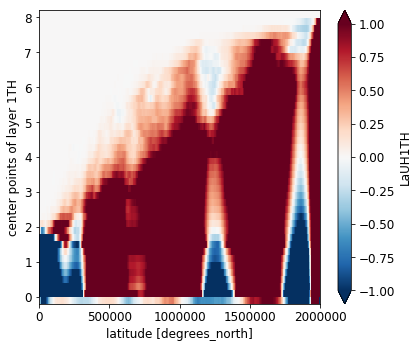

In [25]:
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(6,5))

ds_layers.LaUH1TH.mean(dim=['XG','time']).plot(vmin=-1)

plt.tight_layout()


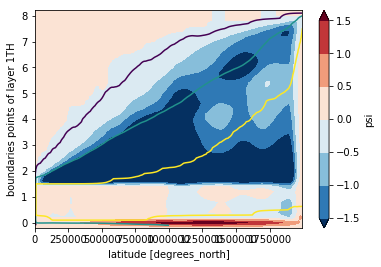

In [45]:
psi = -grid.cumsum((ds_layers.LaVH1TH.mean(dim=('time'))*ds_layers.dxG).sum(dim='XC'), '1TH', boundary='fill').rename('psi')
ds_layers.LaPs1TH.mean(dim=['XC','time']).plot.contour(levels=[0.01,0.5,.999])
(psi / 1e6).plot.contourf(vmin=-1.5)

# Code to calculate the buoyancy fluxes and see what part is along and across mean buoyancy contuors

In [26]:
Model_Tav

<xarray.Dataset>
Dimensions:              (XC: 400, XG: 400, YC: 400, YG: 400, Z: 40, Zl: 40, Zp1: 41, Zu: 40, layer_1TH_bounds: 43, layer_1TH_center: 42, layer_1TH_interface: 41)
Coordinates:
  * XC                   (XC) float32 2500.0 7500.0 ... 1992500.0 1997500.0
  * YC                   (YC) float32 2500.0 7500.0 ... 1992500.0 1997500.0
  * XG                   (XG) float32 0.0 5000.0 10000.0 ... 1990000.0 1995000.0
  * YG                   (YG) float32 0.0 5000.0 10000.0 ... 1990000.0 1995000.0
  * Z                    (Z) float32 -5.0 -15.0 -25.0 ... -2830.5 -2933.5
  * Zp1                  (Zp1) float32 0.0 -10.0 -20.0 ... -2882.0 -2985.0
  * Zu                   (Zu) float32 -10.0 -20.0 -30.0 ... -2882.0 -2985.0
  * Zl                   (Zl) float32 0.0 -10.0 -20.0 ... -2779.0 -2882.0
    rA                   (YC, XC) float32 ...
    dxG                  (YG, XC) float32 ...
    dyG                  (YC, XG) float32 ...
    Depth                (YC, XC) float32 ...
    rAz   

In [27]:
UpTp = grid.interp(Model_Tav.UTtave,'X') - grid.interp(Model_Tav.uVeltave, 'X')*Model_Tav.Ttave
VpTp = grid.interp(Model_Tav.VTtave,'Y', boundary='extend') - grid.interp(Model_Tav.vVeltave, 'Y', boundary='extend')*Model_Tav.Ttave
WpTp = grid.interp(Model_Tav.WTtave,'Z', boundary='extend') - grid.interp(Model_Tav.wVeltave, 'Z', boundary='extend')*Model_Tav.Ttave

In [28]:
T_z = -grid.interp(grid.diff(Model_Tav.Ttave, 'Z', boundary='extend'), 'Z', boundary='extend')/Model_Tav.drF
T_y =  grid.interp(grid.diff(Model_Tav.Ttave, 'Y', boundary='extend'), 'Y', boundary='extend')/5e3
T_x =  grid.interp(grid.diff(Model_Tav.Ttave, 'X'), 'X')/5e3

In [31]:
Fbmod =  (UpTp**2 + VpTp**2 + WpTp**2)**0.5

In [32]:
Fb_dot_gradb = (UpTp*T_x + VpTp*T_y + WpTp*T_z)/ (T_x**2 + T_y**2 + T_z**2)**0.5

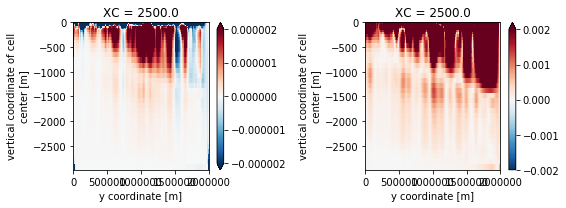

In [41]:
plt.figure(figsize=(8,3))
plt.subplot(121)
Fb_dot_gradb.sel(XC=0, method='nearest').plot(vmin=-2e-6)

plt.subplot(122)
Fbmod.sel(XC=0, method='nearest').plot(vmin=-2e-3)

plt.tight_layout()

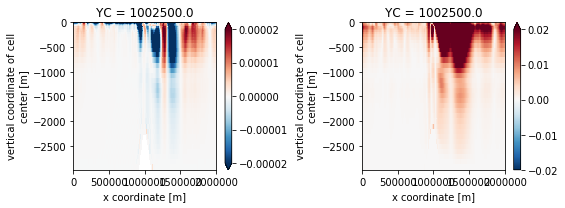

In [46]:
plt.figure(figsize=(8,3))
plt.subplot(121)
Fb_dot_gradb.sel(YC=1000e3, method='nearest').plot(vmin=-2e-5)

plt.subplot(122)
Fbmod.sel(YC=1000e3, method='nearest').plot(vmin=-2e-2)

plt.tight_layout()